# Sanity Check

**Context**
The purpose of this notebook is to **analyze** a dataset containing the **weather history** of the past five years. This analysis aims to identify and address missing data, correct column data types, detect possible input errors, and more. Additionally, it provides an excellent opportunity to **gain initial insights** from the data and extract useful information.

**Data Source**
The data used in this notebook was extracted from the Meteostat API

- **Data:** 29/11/2024
- **Localização:** ../data/raw

## Set up

### Libraries

In [1]:
## Base
import numpy as np
import pandas as pd
import missingno as msno
import os
import calendar

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as py 

# Statistics
from scipy import stats
import statsmodels.api as sm 

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[0].as_posix())

from src.ts_utils import *
from src.data_loader import data_loader

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

### Functions

In [4]:
def visualize_quantity(serie: pd.Series):

    # Visualization
    fig, ax = plt.subplots(2, 1, figsize=(8, 4))

    sns.histplot(x=serie, kde=True, ax=ax[0])

    ax[1] = sns.violinplot(x=serie, inner="quart")
    plt.setp(ax[1].collections, alpha=.5)
    sns.boxplot(x=serie, ax=ax[1])
    
    plt.tight_layout()
    plt.show()

    # Description
    descr_df = serie.describe().reset_index()
    descr_df.columns = ['values', serie.name]

    return descr_df

## Data Extraction
Here, we perform **data extraction** from the API using the "data_loader" code for the selected number of years, in this case, **6 years**.

In [5]:
data_loader(6)

## Data
Downloading the data to verify its integrity

In [6]:
weather_df = pd.read_csv('../data/raw/weather_raw_data.csv')
display(weather_df.tail())
weather_df.info()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
2187,2024-12-19,272.4,270.3,274.2,0.8,0.0,178.0,3.4,NaN,1022.8,NaN
2188,2024-12-20,273.0,268.8,275.3,1.5,25.0,352.0,6.1,NaN,1022.7,NaN
2189,2024-12-21,267.8,265.1,270.3,0.0,NaN,324.0,2.8,NaN,1032.4,NaN
2190,2024-12-22,271.0,265.9,274.2,0.0,79.0,177.0,4.1,NaN,1028.4,NaN
2191,2024-12-23,274.8,271.8,276.8,0.2,130.0,218.0,4.1,NaN,1020.7,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    2192 non-null   object 
 1   tavg    2192 non-null   float64
 2   tmin    2192 non-null   float64
 3   tmax    2192 non-null   float64
 4   prcp    2192 non-null   float64
 5   snow    2191 non-null   float64
 6   wdir    2192 non-null   float64
 7   wspd    2192 non-null   float64
 8   wpgt    0 non-null      float64
 9   pres    2192 non-null   float64
 10  tsun    0 non-null      float64
dtypes: float64(10), object(1)
memory usage: 188.5+ KB


## Integrity
First, we will verify the **integrity of the dataset**, such as duplicates, column types, and more. This analysis is crucial to **ensure data quality** for future analyses and models.

### Data Types
There are two possible types of data in this dataset: **qualitative** and **quantitative**. The qualitative data is associated with date information.

#### Quantity data
**Numerial Data:** tavg, tmin, tmax, prcp, snow, wdir, wspd, wpgt, pres, tsun

In [7]:
quantity_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']
weather_df[quantity_cols] = weather_df[quantity_cols].astype(float)
weather_df[quantity_cols].head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,271.6,268.8,274.2,0.0,0.0,255.0,3.7,NaN,1024.7,NaN
1,275.9,272.0,281.4,0.3,0.0,202.0,2.5,NaN,1026.1,NaN
2,276.6,271.4,282.0,0.0,0.0,125.0,2.4,NaN,1029.6,NaN
3,280.8,277.5,285.3,16.5,0.0,154.0,7.5,NaN,1011.5,NaN
4,276.3,270.9,285.3,0.5,0.0,247.0,8.0,NaN,1010.3,NaN


#### Qualitative data
**Date data:** time

In [8]:
quality_col = 'time'
weather_df[quality_col] = pd.to_datetime(weather_df[quality_col], format="%Y-%m-%d")
weather_df[[quality_col]].head()

,time
0,2018-12-24
1,2018-12-25
2,2018-12-26
3,2018-12-27
4,2018-12-28


### Duplicates
We will remove any duplicate information due to its lack of relevance and potential multiple entries for the same date.

In [9]:
any(weather_df.duplicated())

False

In [10]:
any(weather_df.duplicated('time'))

False

**No duplicated** rows or observations per time observation were found

### Missing Values
Investigation of missing data and its possible correlations

In [11]:
for col in weather_df.columns:
    if any(weather_df[col].isna()):
        n_miss = weather_df[col].isna().sum()
        print('{column_name} - {n_missing} ({missin_percent:.2%})'.format(column_name=col, 
                                                                      n_missing=n_miss, 
                                                                      missin_percent= n_miss/len(weather_df)))

snow - 1 (0.05%)
wpgt - 2192 (100.00%)
tsun - 2192 (100.00%)


The columns '**wpgt**' and '**tsun**' consist only of **NaN observations** and were therefore **removed**

In [12]:
weather_df = weather_df.drop(columns=['wpgt', 'tsun'])

Now, regarding the "**snow**" column, there are **1 missing observations**. Before deciding on the necessary treatment, it is important to **understand these values** and why they are missing: Missing at Random (**MAR**), Missing Completely at Random (**MCAR**), and Missing Not at Random (**MNAR**).

In [13]:
weather_df.sort_values('time', inplace=True)
weather_df.loc[(weather_df['snow'].isna()) | (weather_df['wdir'].isna()), ['time', 'snow', 'wdir']]

,time,snow,wdir
2189,2024-12-21,NaN,324.0


The missing observation is located near the end of the data series. Given this, we have two possible approaches: remove the data starting from the missing observation or fill it using an available method. Considering there are **few missing observations**, we chose to **remove the data starting from the missing observation**.

In [14]:
weather_df = weather_df.loc[weather_df['time'] < pd.to_datetime('2024-12-21')]

## Univariate Analysis
The **univariate analysis** of the variables is the moment where the **individual integrity** of each column is assessed based on the **information they represent**. Standard steps include investigating values that conflict with the nature of the variable, plausible but extreme values and more.

### time
This **variable indicates the day** to which the remaining observations refer, so this variable **should be unique and sequential**.

In [15]:
weather_df['time'].describe()

count                             2189
mean     2021-12-21 23:59:59.999999744
min                2018-12-24 00:00:00
25%                2020-06-23 00:00:00
50%                2021-12-22 00:00:00
75%                2023-06-22 00:00:00
max                2024-12-20 00:00:00
Name: time, dtype: object

In [16]:
date_range = pd.date_range(start=weather_df['time'].min(), end=weather_df['time'].max(), freq='D')
any(weather_df['time'] != date_range)

False

Since "date_range" consists of unique data with no gaps, ranging from the smallest value of "time" to the largest value of the "time" variable, we can **conclude** that the "**time**" variable **is unique** and does **not have any gaps**, as expected.

### tavg
This variable represents the daily average temperature in Kelvin. The minimum value for Kelvin is zero, and there is no upper limit. However, since this value **represents the temperature of the day**, there are **acceptable limits**. Instead of defining these limits upfront, we will **investigate the temperature** distribution and **then decide** whether the **values are acceptable**.

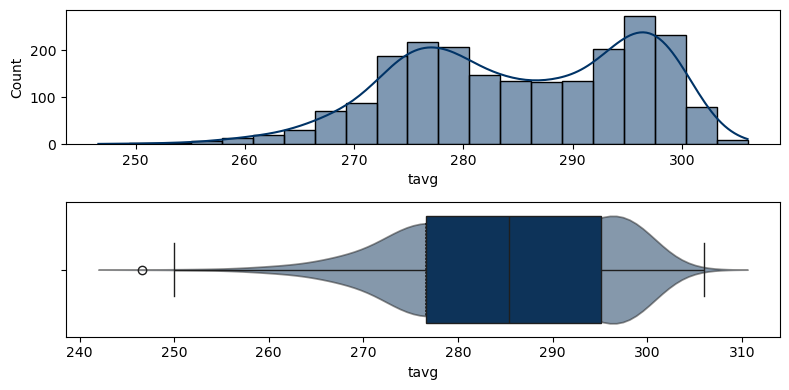

,values,tavg
0,count,2189.000000
1,mean,285.247784
2,std,10.733533
3,min,246.600000
4,25%,276.600000
5,50%,285.400000
6,75%,295.100000
7,max,306.000000


In [17]:
visualize_quantity(weather_df['tavg'])

The **minimum value** identified was 252.10 Kelvin, which is equivalent to -5.89 degrees Fahrenheit, and the **maximum** was 306 Kelvin, or 91.13 degrees Fahrenheit. Both values **are considered acceptable** within a year.

Now, let's **analyze its distribution** in terms of the **time series**. This involves **understanding its trend** and **seasonality**, as well as determining whether it is **stationary** or not.

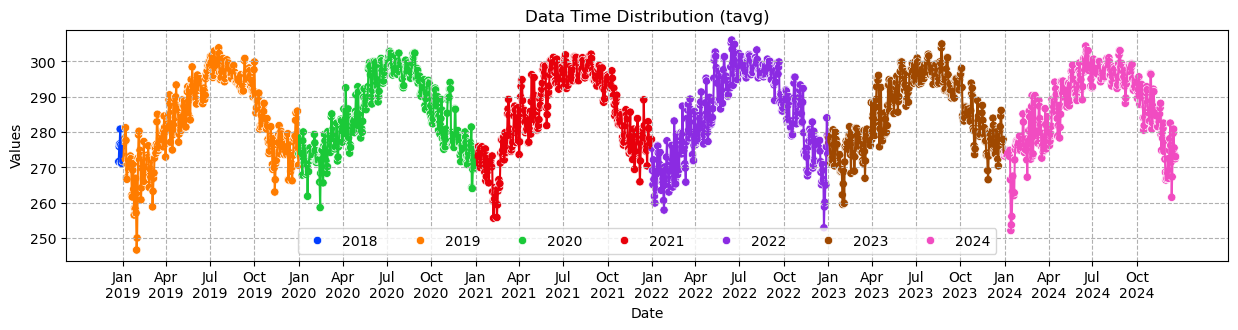

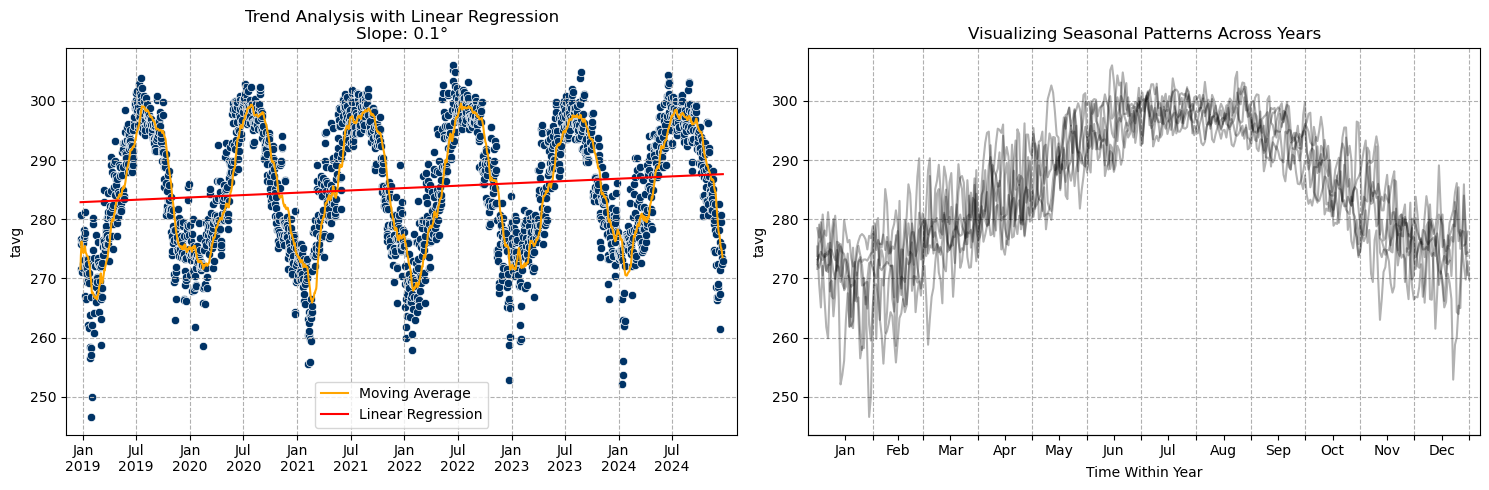

In [18]:
ts_plot(weather_df['tavg'], weather_df['time'])
ts_quick_insights(weather_df['tavg'], weather_df['time'])   

The series exhibits a **clear annual seasonality** with temperature peaks in the middle of the year and lower temperatures at the beginning and end of the year. As for the trend, the linear regression indicates a very shallow slope, so we can conclude that the variable does **not have a significant trend**. Additionally, the **graph suggests** a possible **variation** in the **temperature fluctuation** over time. **If this is confirmed**, it would indicate that the **data is heteroscedastic**, introducing a new level of complexity.

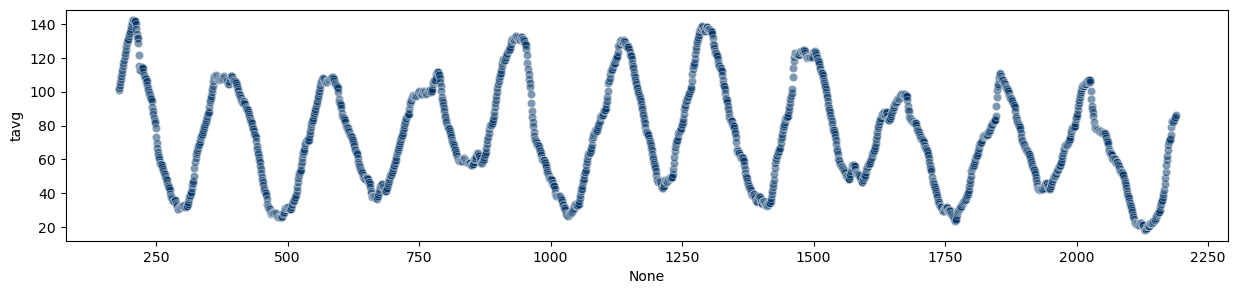

In [19]:
variance_temp = weather_df['tavg'].rolling(180).var() # Variation by semester
variance_temp = variance_temp.dropna()

plt.figure(figsize=(15, 3))
sns.scatterplot(x=variance_temp.index, y=variance_temp, alpha=0.5)
plt.show()

**Based on the graph** above, we can conclude that the data **is indeed heteroscedastic**, as it exhibits **seasonal variance**. This indicates that the series is also **not stationary**.

In [20]:
stationary_tests(weather_df['tavg'])

Augmented Dickey-Fuller (ADF) - p-value: 9.96%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


look-up table. The actual p-value is greater than the p-value returned.



### tmin & tmax

The **variables "tmin" and "tmax"** are intrinsically **linked** to the **target variable** "tavg". At first glance, this could mean they are excellent predictor variables. However, in practice, their modeling is as complex as that of the target variable, and their lag values are just as informative as the lags of the target, making **these variables less useful** for modeling, as we can see below.

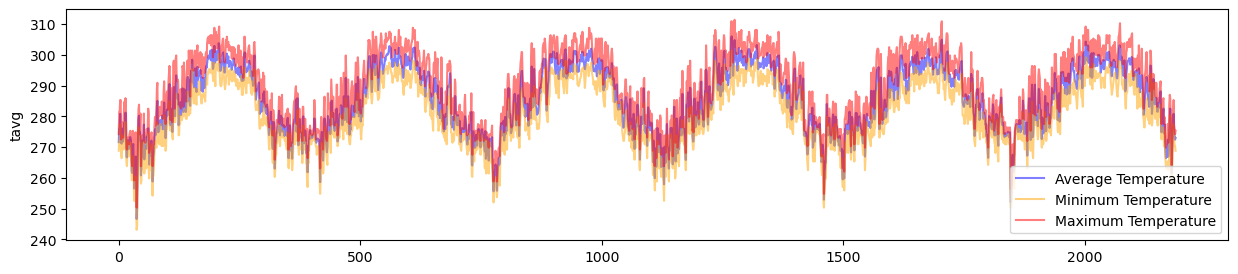

In [21]:
plt.figure(figsize=(15, 3))
sns.lineplot(weather_df['tavg'], alpha=0.5, color='blue', label='Average Temperature')
sns.lineplot(weather_df['tmin'], alpha=0.5, color='orange', label='Minimum Temperature')
sns.lineplot(weather_df['tmax'], alpha=0.5, color='red', label='Maximum Temperature')
plt.show()

Although the variables individually do not provide new information for the analysis, together they offer meaningful insight: **temperature amplitude**. This strictly positive variable **can be useful** for **understanding the target** behavior.

In [22]:
weather_df['tamp'] = weather_df['tmax'] - weather_df['tmin']
weather_df.drop(columns=['tmax', 'tmin'], inplace=True)
weather_df['tamp'].describe()

count    2189.000000
mean        9.025994
std         3.655120
min         1.000000
25%         6.500000
50%         8.900000
75%        11.600000
max        22.200000
Name: tamp, dtype: float64

Considering that this new variable, "**tamp**", is also a time series, it is important to **visualize its behavior** over time and determine whether it is **stationary** or not.

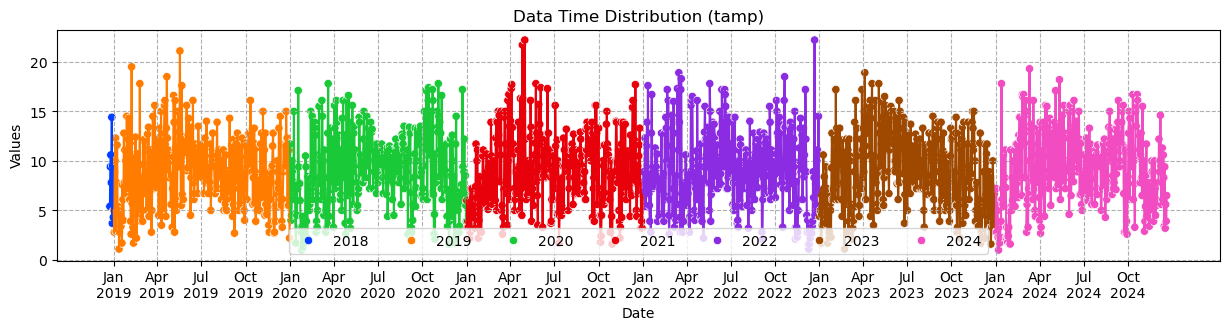

In [23]:
ts_plot(weather_df['tamp'], weather_df['time'])

In [24]:
stationary_tests(weather_df['tamp'])

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


look-up table. The actual p-value is greater than the p-value returned.



Therefore, we conclude that the **data is stationary**.

### prcp
This variable contains the daily **precipitation volume in mm**. It may be directly linked to the average temperature.

In [25]:
weather_df['prcp'].describe()

count    2189.000000
mean        2.918045
std         8.005947
min         0.000000
25%         0.000000
50%         0.000000
75%         1.500000
max       101.900000
Name: prcp, dtype: float64

The statistics above indicate that it **does not rain for most of the year**. It is necessary to **investigate** whether the **maximum value** is valid or not.

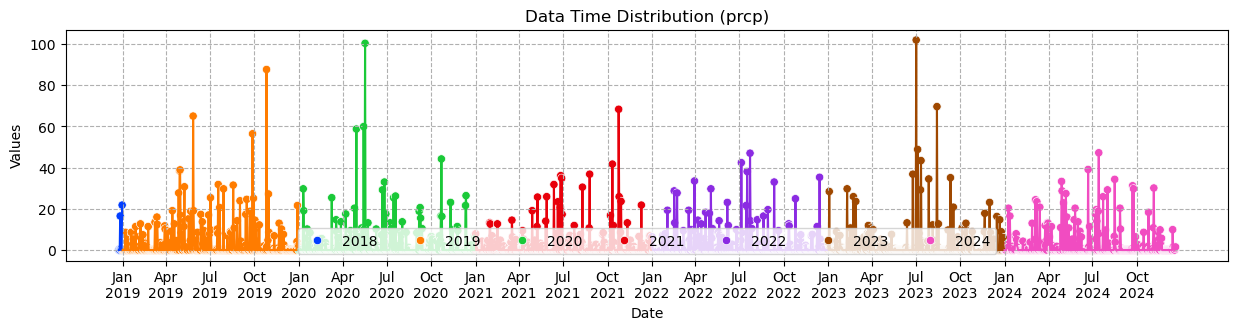

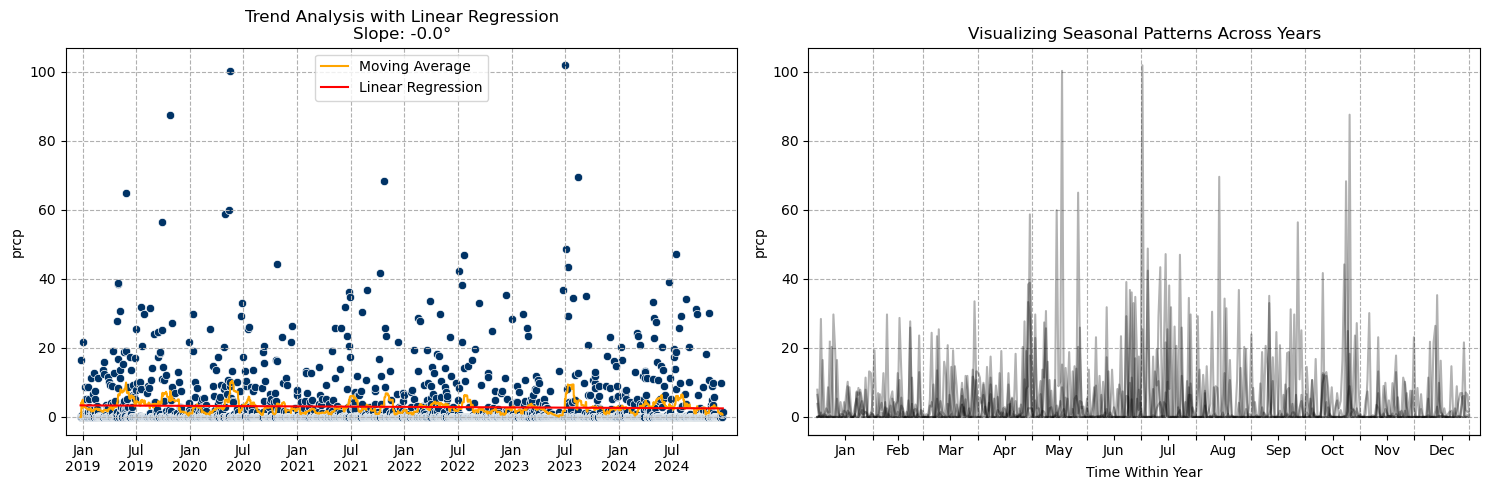

In [26]:
ts_plot(weather_df['prcp'], weather_df['time'])
ts_quick_insights(weather_df['prcp'], weather_df['time'])   

Precipitations well **above 50 mm** are often considered extreme rainfall and are associated with **significant meteorological events**.

In [27]:
weather_df.sort_values('prcp').tail(10)

,time,tavg,prcp,snow,wdir,wspd,pres,tamp
1654,2023-07-05,299.8,48.8,0.0,195.0,3.0,1012.6,11.6
277,2019-09-27,291.6,56.4,0.0,195.0,5.2,1008.3,6.0
492,2020-04-29,284.9,58.7,0.0,297.0,5.4,999.3,11.0
507,2020-05-14,289.8,59.9,0.0,187.0,3.9,1012.9,10.0
154,2019-05-27,291.0,65.0,0.0,104.0,3.1,1012.3,11.6
1035,2021-10-24,282.2,68.3,0.0,78.0,5.2,1013.2,6.1
1694,2023-08-14,294.8,69.6,0.0,50.0,3.4,1010.5,6.6
306,2019-10-26,280.8,87.6,0.0,73.0,5.1,1012.3,6.8
510,2020-05-17,289.3,100.3,0.0,129.0,3.9,1008.6,7.8
1651,2023-07-02,294.1,101.9,0.0,9.0,3.9,1006.7,5.0


As expected, the rainfall on the days [**2019-10-26**](https://www.weather.gov/lot/26Oct2019_flood), [**2020-05-17**](https://www.weather.gov/lot/17may2020) and [**2023-07-02**](https://www.weather.gov/lot/2023_07_02_Flooding) are associated with **extreme events**, as the hyperlinks linked to the dates demonstrate.

We have determined that the data does **not contain irregular** values but does **have outliers**. The graphs do **not show** the presence of a **trend** or **seasonality**.

### snow

The variable "**snow**" indicates the **daily snowfall volume** in millimeters. Snow, naturally, has a strong relationship with temperature, as very low temperatures are required for snow to occur.

In [28]:
weather_df['snow'].describe()

count    2189.000000
mean        9.292828
std        46.325695
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       660.000000
Name: snow, dtype: float64

As expected, there is **no snowfall** for **most of the years**.

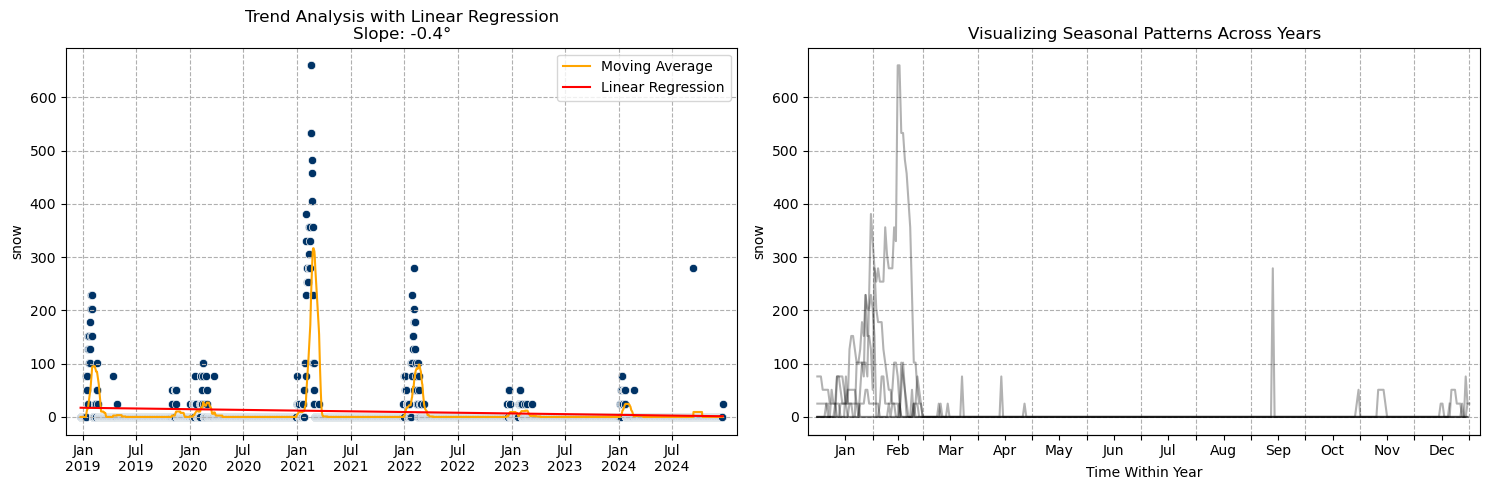

In [29]:
ts_quick_insights(weather_df['snow'], weather_df['time'])

Most of the **snowfall periods** occur at the **beginning of the year**, as we observed that this is the period with the **lowest temperatures**.

### wdir
The **average wind direction** is measured in **degrees**, with well-defined limits ranging **from 0 to 360 degrees**. Although the data is numerical, the nature of the information it represents means that some mathematical properties, such as proportionality, do not apply. For example, 180 degrees indicates the opposite direction of 90 degrees, not "twice" the direction. With that in mind, **after verifying its integrity**, we will **transform** this variable into a categorical variable, 'wcardinal,' which represents the 8 **cardinal points**.

In [30]:
weather_df['wdir'].describe()

count    2189.000000
mean      185.090909
std       101.315986
min         0.000000
25%        84.000000
50%       206.000000
75%       263.000000
max       359.000000
Name: wdir, dtype: float64

Assuming that **North** corresponds to **zero degrees**. Let’s **categorize** the data into **cardinal points** (North, Northeast, South, etc.) to help us understand its behavior. Each **cardinal point has** a range of **45 degrees**.

In [31]:
cardinal_range = [-0.1] + list(np.arange(22.5, 360, 45)) + [360]
weather_df['wcardinal'] = pd.cut(weather_df['wdir'], cardinal_range, ordered=False, 
                                 labels=['North', 'Northeast', 'East', 'Southeast', 
                                         'South', 'Southwest', 'West', 'Northwest', 'North'])

weather_df.drop(columns=['wdir'], inplace=True)
weather_df['wcardinal'].value_counts()

wcardinal
Southwest    434
West         363
Northeast    350
South        312
Northwest    232
North        222
East         154
Southeast    122
Name: count, dtype: int64

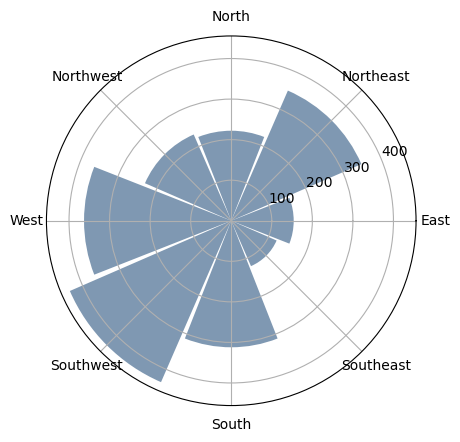

In [32]:
cardinal_volume = weather_df['wcardinal'].value_counts()
cardinal_volume = cardinal_volume.reindex(['East', 'Northeast', 'North','Northwest', 'West', 'Southwest', 'South', 'Southeast'])
angles = np.linspace(0, 2 * np.pi, len(cardinal_volume.index), endpoint=False)

# Visualization
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.bar(angles, cardinal_volume, width=0.75, bottom=0.0, alpha=0.5)

ax.set_xticks(angles)
ax.set_xticklabels(cardinal_volume.index)
plt.show()

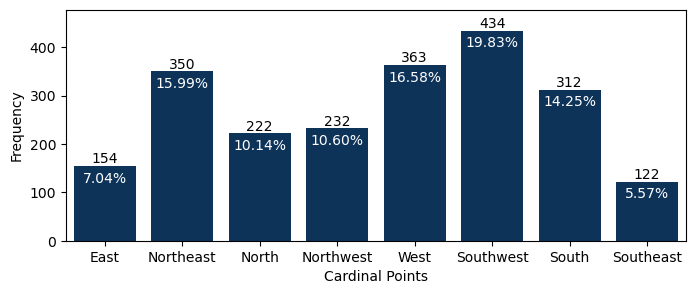

In [33]:
plt.figure(figsize=(8, 3))

sns.barplot(cardinal_volume)

for i, freq in enumerate(cardinal_volume):
    total_freq = cardinal_volume.sum()
    p = freq/total_freq
    plt.annotate(freq, xy=(i, freq), ha='center', va='bottom')
    plt.annotate('{:.2%}'.format(p), xy=(i, freq - total_freq*0.005), ha='center', va='top', color='w')

plt.xlabel('Cardinal Points')
plt.ylabel('Frequency')
plt.ylim(0, cardinal_volume.max()*1.1)
plt.show()

Both graphs contain the same information but are presented in different ways. Here, we can observe **large concentrations** of days with winds coming from the **southeast** and **northeast** directions.

### wspd
**Average wind speed** in km/h. This information is closely **related** to the "**wdir**", therefore, be **analyzed** both **independently** and in **conjunction** with it.

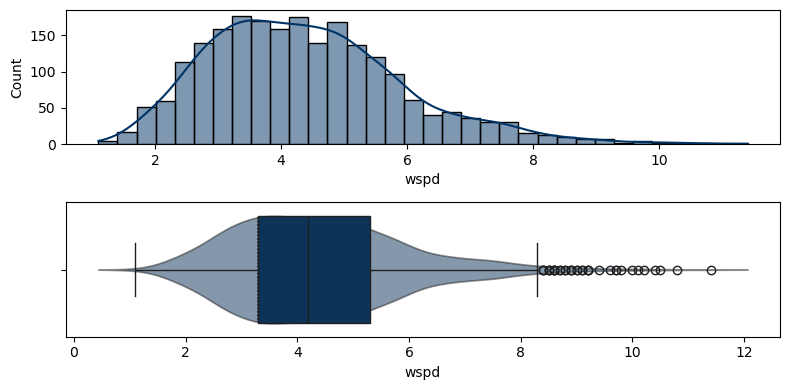

,values,wspd
0,count,2189.000000
1,mean,4.398995
2,std,1.537855
3,min,1.100000
4,25%,3.300000
5,50%,4.200000
6,75%,5.300000
7,max,11.400000


In [34]:
visualize_quantity(weather_df['wspd'])

Based on the **graph above**, it is possible to observe that the **distribution is not symmetrical**, with a **heavier right tail**, indicating the presence of **outliers**. Now, let's analyze the distributions by cardinal point.

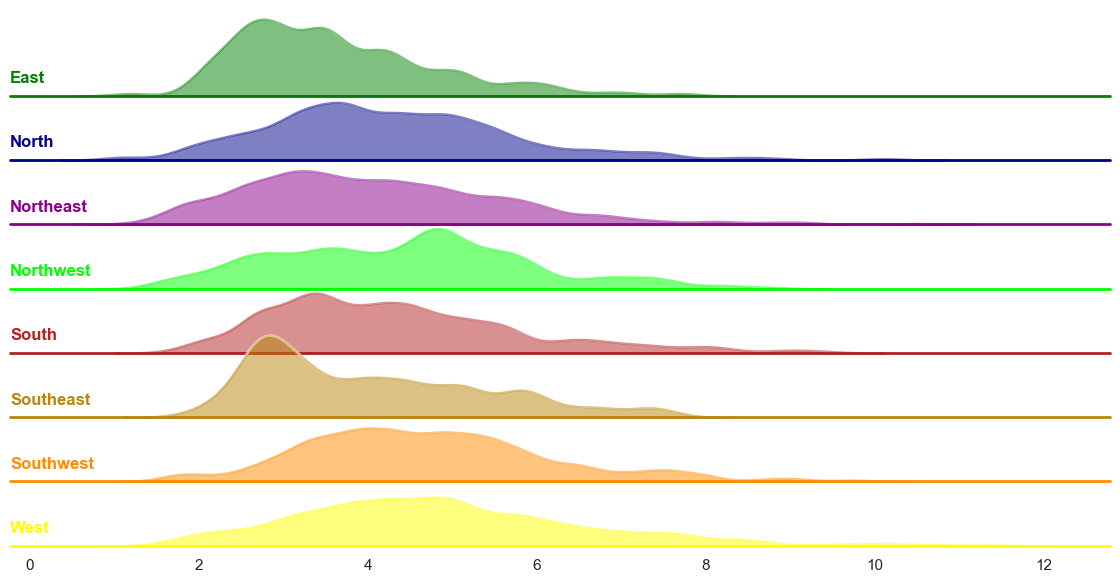

In [35]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = {'North': 'darkblue', 'South': 'firebrick', 'East': 'green', 'West': 'yellow',
       'Northwest': 'lime', 'Northeast': 'darkmagenta', 'Southeast': 'darkgoldenrod', 'Southwest': 'darkorange'}
g = sns.FacetGrid(weather_df, row="wcardinal", hue="wcardinal", aspect=15, height=.8, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "wspd",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=0.5, linewidth=1.5)
g.map(sns.kdeplot, "wspd", clip_on=False, color="w", alpha=0.5, lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "wspd")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_axis_labels("", "")  # Remove os rótulos dos eixos
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()


In [36]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

In [37]:
weather_df.groupby('wcardinal', observed=False)[['wspd']].describe()

wspd                                                  
           count      mean       std  min    25%  50%    75%   max
wcardinal                                                         
East       154.0  3.622078  1.162724  1.2  2.725  3.4  4.200   7.7
North      222.0  4.273874  1.457836  1.1  3.300  4.2  5.100  10.1
Northeast  350.0  4.085429  1.521626  1.2  3.000  3.9  5.000  10.5
Northwest  232.0  4.413793  1.466267  1.5  3.375  4.5  5.325   8.7
South      312.0  4.345833  1.490176  1.7  3.200  4.1  5.100   9.4
Southeast  122.0  4.035246  1.360416  1.9  2.900  3.8  5.000   7.5
Southwest  434.0  4.724654  1.468284  1.6  3.700  4.6  5.575   9.8
West       363.0  4.876584  1.718128  1.6  3.700  4.7  5.800  11.4

Based on the **quartiles** and the **graph**, there are **strong indications** that **wind speed is not related to its direction**. Now, let's analyze the distribution of the data over time.

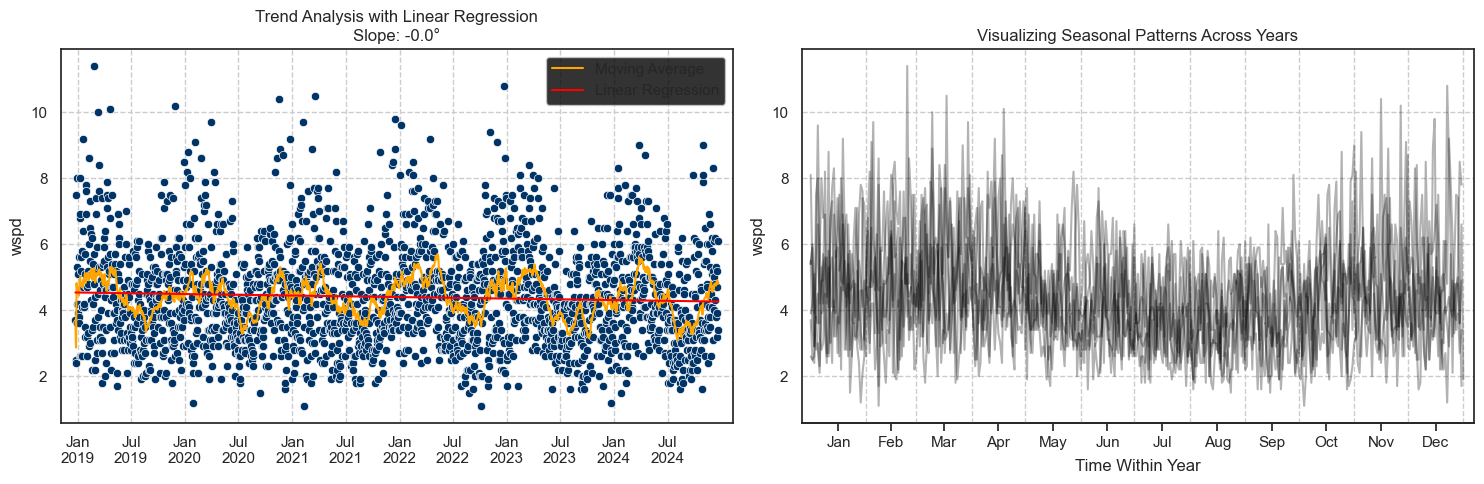

In [38]:
ts_quick_insights(weather_df['wspd'], weather_df['time'])

By **observing the data over the timeline**, we can identify an **annual seasonal** pattern as well as the **absence of a trend**.

### pres
The **average air pressure** at sea level in hPa.

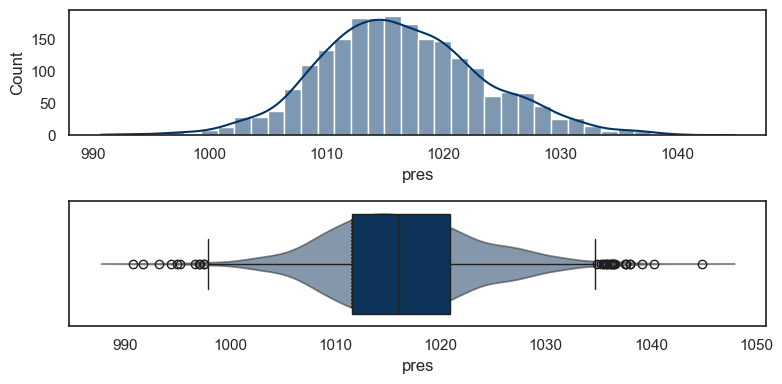

,values,pres
0,count,2189.000000
1,mean,1016.431339
2,std,7.091019
3,min,990.700000
4,25%,1011.600000
5,50%,1015.900000
6,75%,1020.900000
7,max,1044.900000


In [39]:
visualize_quantity(weather_df['pres'])

The **data appear** to be **symmetrical and bell-shaped**, so we will **test for normality** in this sample.

In [40]:
print('H0: The sample comes from a normal distribution\nHa: The sample does not come from a normal distribution')

stats.shapiro(weather_df['pres'])

H0: The sample comes from a normal distribution
Ha: The sample does not come from a normal distribution


ShapiroResult(statistic=0.9944330233603924, pvalue=2.49815305508048e-07)

In [41]:
print('H0: The sample comes from a normal distribution\nHa: The sample does not come from a normal distribution')
stats.jarque_bera(weather_df['pres'])

H0: The sample comes from a normal distribution
Ha: The sample does not come from a normal distribution


SignificanceResult(statistic=29.220664345760703, pvalue=4.516617974644459e-07)

Based on the **tests above**, we **conclude** that despite the bell-shaped distribution, the data were **not drawn from a normal distribution**. Now, let's analyze the distribution of the data over time.

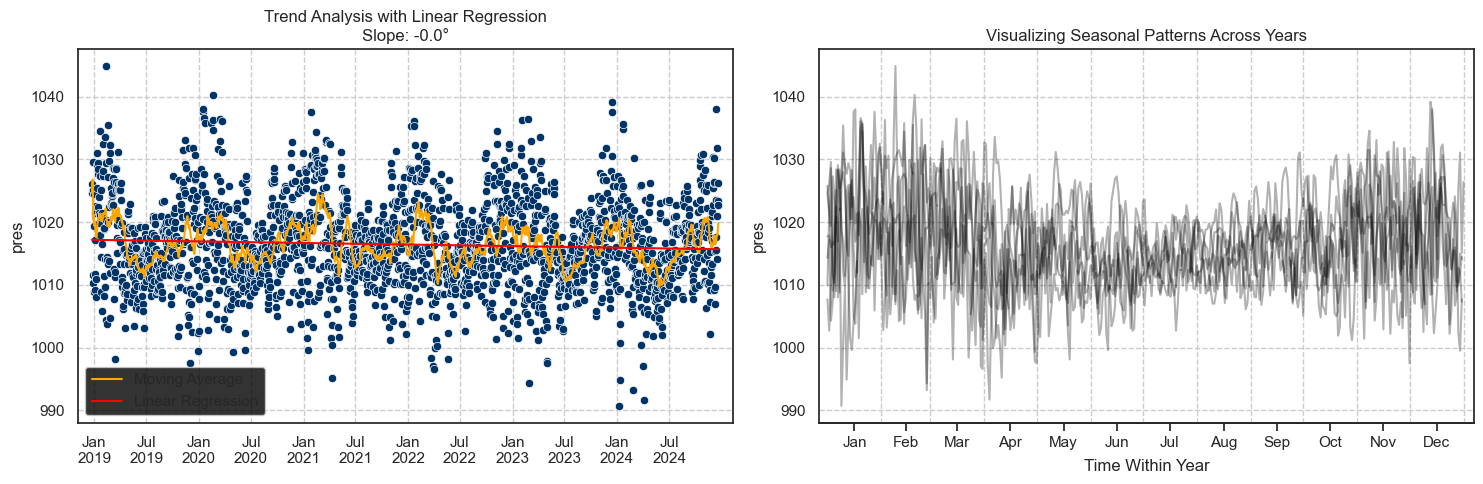

In [42]:
ts_quick_insights(weather_df['pres'], weather_df['time'])

By **observing the data over time**, we can identify an **annual seasonal pattern** as well as the **absence of a trend**, similar to most of the other data

## Conclusion
In conclusion, the **data** are of **sufficient quality** to proceed to the **next stage**, which is the **exploratory analysis** for modeling.

## Saving Data

In [43]:
display(weather_df.head())
weather_df.info()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal
0,2018-12-24,271.6,0.0,0.0,3.7,1024.7,5.4,West
1,2018-12-25,275.9,0.3,0.0,2.5,1026.1,9.4,South
2,2018-12-26,276.6,0.0,0.0,2.4,1029.6,10.6,Southeast
3,2018-12-27,280.8,16.5,0.0,7.5,1011.5,7.8,Southeast
4,2018-12-28,276.3,0.5,0.0,8.0,1010.3,14.4,Southwest


<class 'pandas.core.frame.DataFrame'>
Index: 2189 entries, 0 to 2188
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       2189 non-null   datetime64[ns]
 1   tavg       2189 non-null   float64       
 2   prcp       2189 non-null   float64       
 3   snow       2189 non-null   float64       
 4   wspd       2189 non-null   float64       
 5   pres       2189 non-null   float64       
 6   tamp       2189 non-null   float64       
 7   wcardinal  2189 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(6)
memory usage: 139.3 KB


In [44]:
weather_df.to_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_sanitized.parquet'))